# Import The Needed Libraries

In [1]:
!pip install openpyxl

     |████████████████████████████████| 242 kB 799 kB/s            


In [2]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

# 1- **Importing data**

In [3]:
data = pd.read_excel("../input/dummy-excel/Dummy dataset.xlsx")

# 2- **EDA**

>## 2.1 Exploring the data

In [4]:
data.head()

,Total O/S,TENOR_@Booking,Loan Term,BOOKING_DATE,MATURITY_DATE,DPD,DOB,AGE,AGE at Maturity,GENDER,Customer Segment
0,178630.00,120,10 Years,2019-07-31,2029-04-03,0,1983-06-23,38.469863,48.04,MALE,Salaried
1,376444.57,120,10 Years,2019-03-04,2028-07-03,0,1963-09-30,58.212329,67.12,MALE,Salaried
2,253984.28,84,7 Years,2019-05-05,2025-07-03,0,1965-02-24,56.806849,63.08,MALE,Salaried
3,779620.11,108,9 Years,2021-04-26,2030-04-25,5,1983-12-01,38.028767,46.1,MALE,Self Employed & Professional
4,103377.43,60,5 Years,2021-04-27,2026-04-25,0,1981-08-08,40.343836,45.02,MALE,Salaried


In [5]:
#number of rows and columns
print(f'dataset shape is {data.shape}')

dataset shape is (38685, 11)


In [6]:
#Which ones are categorical and which are numerical?
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38685 entries, 0 to 38684
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Total O/S         38685 non-null  float64       
 1   TENOR_@Booking    38685 non-null  int64         
 2   Loan Term         38685 non-null  object        
 3   BOOKING_DATE      38685 non-null  datetime64[ns]
 4   MATURITY_DATE     38685 non-null  datetime64[ns]
 5    DPD              38685 non-null  int64         
 6   DOB               38601 non-null  datetime64[ns]
 7   AGE               38601 non-null  float64       
 8   AGE at Maturity   38601 non-null  object        
 9   GENDER            38677 non-null  object        
 10  Customer Segment  38666 non-null  object        
dtypes: datetime64[ns](3), float64(2), int64(2), object(4)
memory usage: 3.2+ MB


In [7]:
data.describe()

,Total O/S,TENOR_@Booking,DPD,AGE
count,3.868500e+04,38685.000000,38685.000000,38601.000000
mean,1.851946e+05,86.300271,13.760838,44.144009
std,5.719265e+05,27.832914,63.639185,10.003271
min,5.000000e-02,12.000000,0.000000,-76.269863
25%,3.599904e+04,60.000000,0.000000,36.941096
50%,9.071416e+04,84.000000,0.000000,43.434247
75%,1.869215e+05,108.000000,0.000000,50.875342
max,8.170000e+07,120.000000,2470.000000,86.341096


>## 2.2 Dealing with Nulls

NULLs exits in the dataset in the form of an attribute called ##### or null value, so we first replace both ##### with NULLs and then decide the best action for each attribute

In [8]:
data.replace(to_replace = "#", value=np.NaN, inplace= True, regex= True)

In [9]:
data.drop(data[data['AGE'] < 1].index, inplace = True)

In [10]:
data.isnull().sum()

Total O/S            0
TENOR_@Booking       0
Loan Term            0
BOOKING_DATE         0
MATURITY_DATE        0
 DPD                 0
DOB                 84
AGE                 84
AGE at Maturity     84
GENDER               8
Customer Segment    19
dtype: int64

Number of nulls is too few so we can just drop them.

In [11]:
data.dropna(inplace = True)

>## 2.3 Dealing with Duplicates

In [12]:
data.duplicated().sum()

794

In [13]:
#drop duplicates
data.drop_duplicates(inplace = True)

>## 2.4 Dealing with Total Loan Amount

In [14]:
minValue = 10000
maxValue = 5000000

In [15]:
data.loc[data['Total O/S'] < minValue, 'Total O/S'] = minValue

In [16]:
data.loc[data['Total O/S'] > maxValue, 'Total O/S'] = maxValue

>## 2.5 Dealing with Age

In [17]:
minValue = 21
maxValue = 60

In [18]:
data.loc[data['AGE'] < minValue, 'AGE'] = minValue

In [19]:
data.loc[data['AGE'] > maxValue, 'AGE'] = maxValue

>## 2.6 Dealing with Date Features

In [20]:
data['MATURITY_DATE_year'] = data['MATURITY_DATE'].dt.year

In [21]:
data['BOOKING_DATE_year'] = data['BOOKING_DATE'].dt.year

>## 2.7 Encoding Categorical Features



Since encoding Loan Term feature should reflect the sequence, we use ordinal encoder.

In [22]:
loan_term_encoder= ce.OrdinalEncoder(cols=['Loan Term'],return_df=True,
                           mapping=[{'col':'Loan Term',
'mapping':{'1 Year':1, '2 Years':2,'3 Years':3,'4 Years':4,'5 Years':5,'6 Years':6, '7 Years': 7, '8 Years': 8, '9 Years': 9, '10 Years': 10, 'More than 10 Years': 11}}])

In [23]:
data['Loan Term'] = loan_term_encoder.fit_transform(data['Loan Term'])

We can encode Gender feature by replacing male and female with one and zero.

In [24]:
data["GENDER"].replace({"MALE":1,"Male":1, "FEMALE":0, "Female":0}, inplace = True)

We can encode Customer Segment feature by replacing Salaried and Self Employed & Professional with one and zero.

In [25]:
data["Customer Segment"].replace({"Salaried":1, "Self Employed & Professional":0}, inplace = True)

>## 2.8 Correlation Between Features

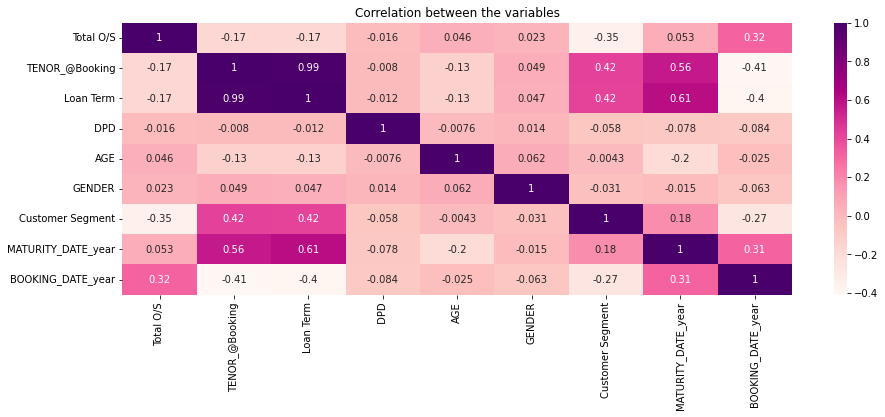

In [26]:
#heatmap for different features
fig, ax = plt.subplots(figsize=(15,5))         # Sample figsize in inches
sns.heatmap(data.corr(), annot = True, ax=ax, cmap="RdPu");
plt.title('Correlation between the variables')
plt.xticks(rotation=90);

>## 2.9 Some Statistics



In [27]:
colors = ['steelblue','rosybrown','skyblue', 'plum', 'darkviolet','springgreen','chocolate', 'lightseagreen', 'lightcoral',  'gold', 'grey',  'pink']

>> ### 1) What is the distribution of each gender in the dataset?

In [28]:
gender_labels = data['GENDER'].value_counts().keys().tolist()
if gender_labels[0]:
  gender_labels[0] = 'male'
  gender_labels[1] = 'female'
else:
  gender_labels[0] = 'female'
  gender_labels[1] = 'male'
gender_count  = data['GENDER'].value_counts().tolist()

<function matplotlib.pyplot.show(close=None, block=None)>

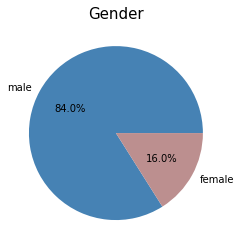

In [29]:
plt.pie(gender_count, labels = gender_labels, autopct='%1.1f%%', colors = colors)
plt.title('Gender', fontdict={'fontsize':15})
plt.show

>> ### 2) What is the distribution of each loan category in the dataset?

In [30]:
loan_term_labels = data['Loan Term'].value_counts().keys().tolist()
x =[i for i in range(len(loan_term_labels)) if loan_term_labels[i] == 11]
loan_term_labels[x[0]] = '>10'
loan_term_count  = data['Loan Term'].value_counts().tolist()

<function matplotlib.pyplot.show(close=None, block=None)>

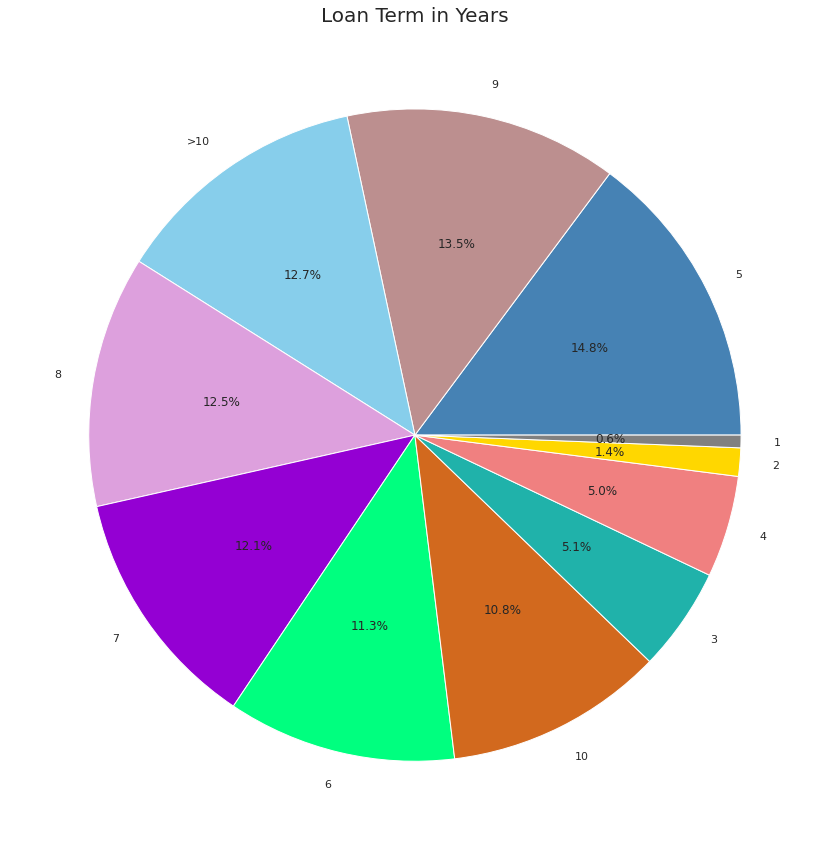

In [31]:
sns.set(rc = {'figure.figsize':(15,15)})
plt.pie(loan_term_count, labels = loan_term_labels, autopct='%1.1f%%', colors = colors)
plt.title('Loan Term in Years', fontdict={'fontsize':20})
plt.show

>>### 3) What is the relation between Age and Loan Term (years)?

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


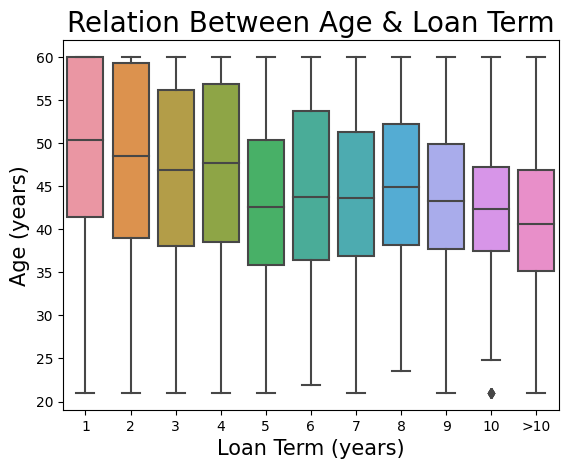

In [32]:
sns.reset_defaults()
plt_data = data.sort_values("Loan Term")
plt_data['Loan Term'].replace({11: '>10'}, inplace = True)
sns.boxplot(plt_data['Loan Term'], plt_data['AGE'])
plt.title('Relation Between Age & Loan Term', fontdict={'fontsize':20})
plt.xlabel('Loan Term (years)', fontsize=15)
plt.ylabel('Age (years)', fontsize=15)
plt.show()

>>### 4) What is the relation between Gender and Loan Term (years)?

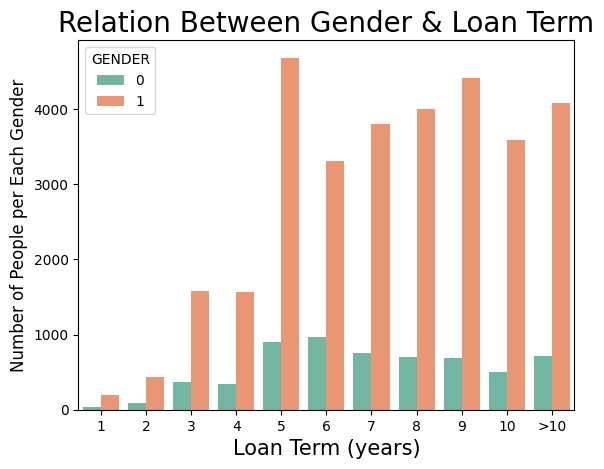

In [33]:
sns.countplot(x='Loan Term', hue='GENDER', data=plt_data, palette='Set2')
plt.title('Relation Between Gender & Loan Term', fontdict={'fontsize':20})
plt.xlabel('Loan Term (years)', fontsize=15)
plt.ylabel('Number of People per Each Gender', fontsize=12)
plt.show()

>>### 5) What is the relation between Segment and Loan Term (years)?

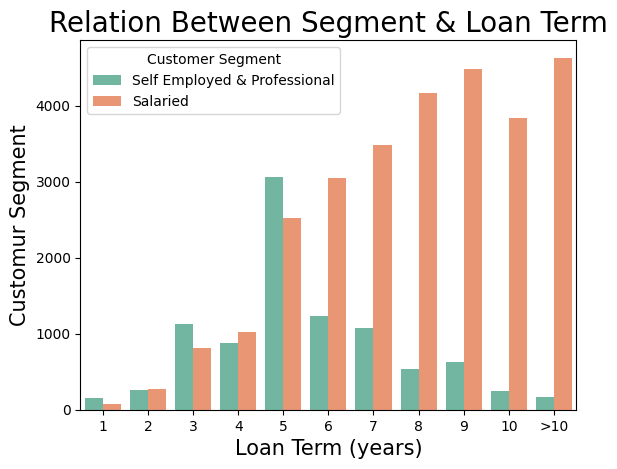

In [34]:
plt_data['Customer Segment'].replace({1: "Salaried", 0: "Self Employed & Professional" }, inplace = True)
sns.countplot(x='Loan Term', hue='Customer Segment', data=plt_data, palette='Set2')
plt.title('Relation Between Segment & Loan Term', fontdict={'fontsize':20})
plt.xlabel('Loan Term (years)', fontsize=15)
plt.ylabel('Customur Segment', fontsize=15)
plt.show()

>>### 6) What is the relation between Booking Date (year) and Loan Term (years)?

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


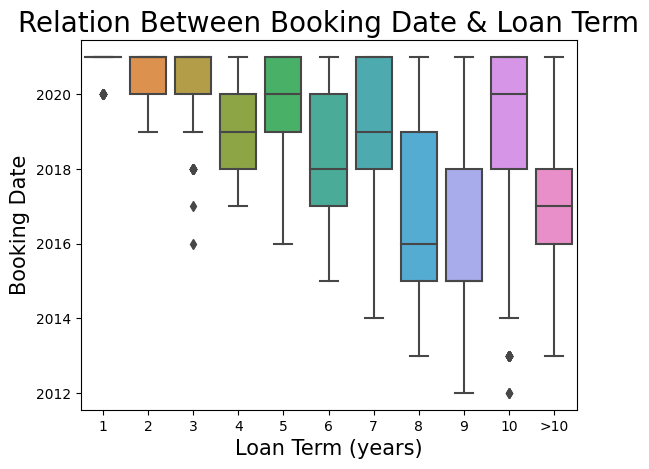

In [35]:
sns.boxplot(plt_data['Loan Term'], plt_data['BOOKING_DATE_year'])
plt.title('Relation Between Booking Date & Loan Term', fontdict={'fontsize':20})
plt.xlabel('Loan Term (years)', fontsize=15)
plt.ylabel('Booking Date', fontsize=15)
plt.show()

>>### 7) What is the relation between Age and Total Loan Amount?

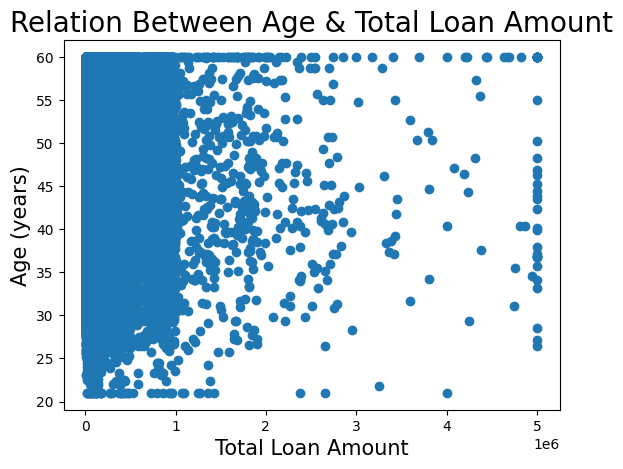

In [36]:
plt.scatter(plt_data['Total O/S'], plt_data['AGE'])
plt.title('Relation Between Age & Total Loan Amount', fontdict={'fontsize':20})
plt.xlabel('Total Loan Amount', fontsize=15)
plt.ylabel('Age (years)', fontsize=15)
plt.show()

>>### 8) What is the relation between Gender and Total Loan Amount?

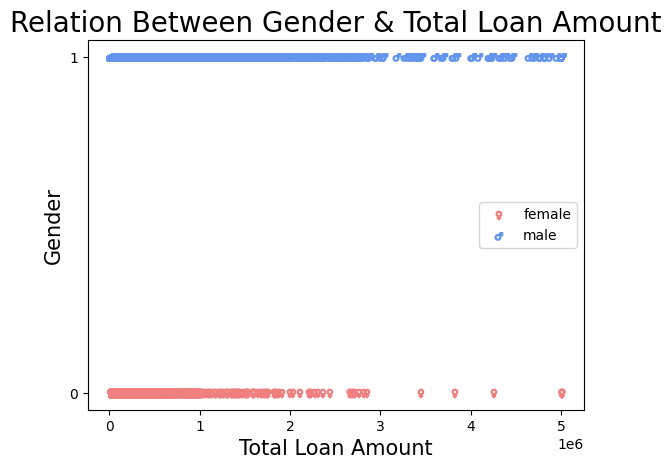

In [37]:
plt_female = plt_data.loc[plt_data['GENDER'] == 0]
plt_male = plt_data.loc[plt_data['GENDER'] == 1]
plt.scatter(plt_female['Total O/S'], plt_female['GENDER'],c='lightcoral', marker = u'$\u2640$', label='female')
plt.scatter(plt_male['Total O/S'], plt_male['GENDER'], c='cornflowerblue', marker = u'$\u2642$', label='male')
plt.title('Relation Between Gender & Total Loan Amount', fontdict={'fontsize':20})
plt.xlabel('Total Loan Amount', fontsize=15)
plt.ylabel('Gender', fontsize=15)
plt.yticks(np.arange(0, 2, 1))
plt.legend()
plt.show()

>>### 9) What is the relation between Segment and Total Loan Amount?

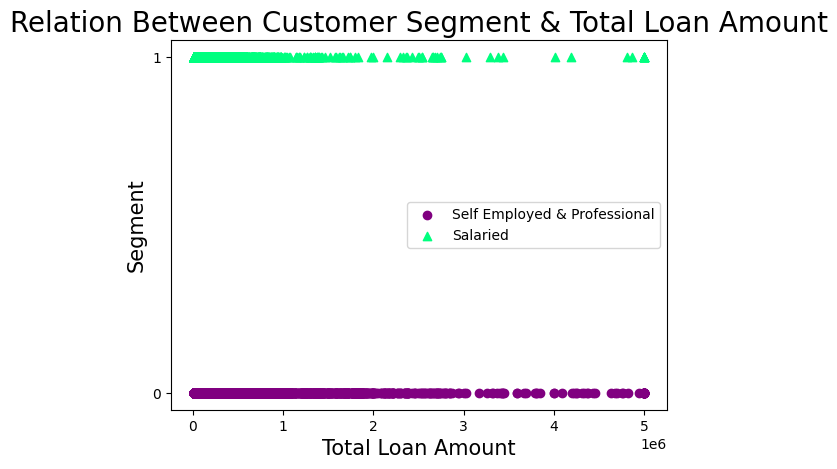

In [38]:
plt_data.replace({'Salaried': 1, 'Self Employed & Professional':0 }, inplace = True)
plt_salaried = plt_data.loc[plt_data['Customer Segment'] == 0]
plt_self = plt_data.loc[plt_data['Customer Segment'] == 1]
plt.scatter(plt_salaried['Total O/S'], plt_salaried['Customer Segment'],c='purple', marker = 'o', label='Self Employed & Professional')
plt.scatter(plt_self['Total O/S'], plt_self['Customer Segment'], c='springgreen', marker = '^', label='Salaried')
plt.title('Relation Between Customer Segment & Total Loan Amount', fontdict={'fontsize':20})
plt.xlabel('Total Loan Amount', fontsize=15)
plt.ylabel('Segment', fontsize=15)
plt.yticks(np.arange(0, 2, 1))
plt.legend()
plt.show()

>>### 10) What is the relation between Booking Date (year) and Total Loan Term?

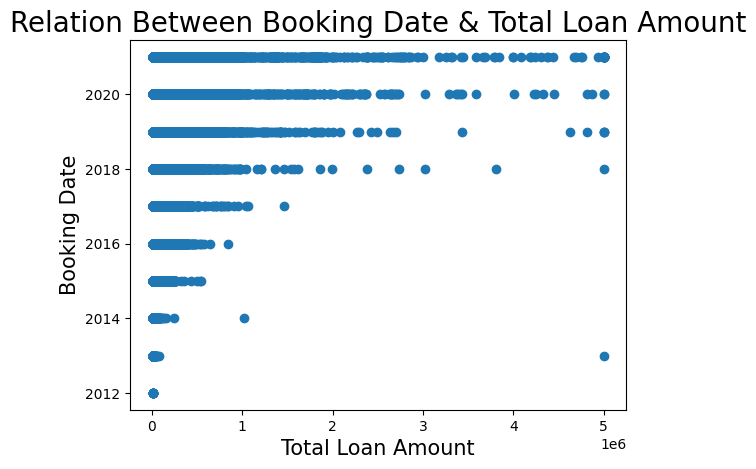

In [39]:
plt.scatter(plt_data['Total O/S'], plt_data['BOOKING_DATE_year'])
plt.title('Relation Between Booking Date & Total Loan Amount', fontdict={'fontsize':20})
plt.xlabel('Total Loan Amount', fontsize=15)
plt.ylabel('Booking Date', fontsize=15)
plt.show()

>>### 11) What is the relation between Loan Term (years) and Total Loan Term?

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


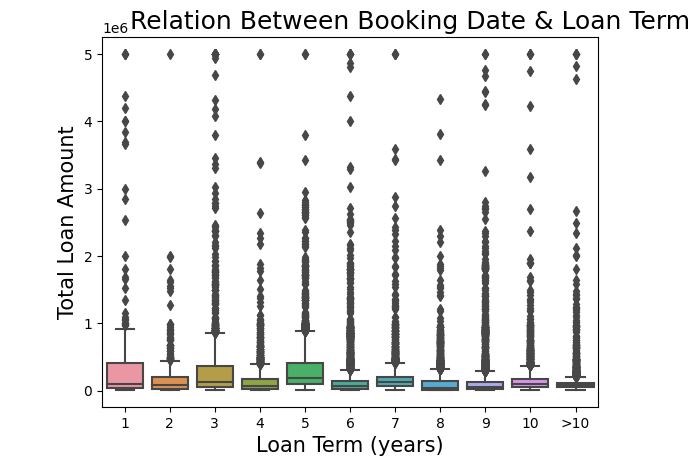

In [40]:
sns.boxplot(plt_data['Loan Term'], plt_data['Total O/S'])
plt.title('               Relation Between Booking Date & Loan Term', fontdict={'fontsize':18})
plt.xlabel('Loan Term (years)', fontsize=15)
plt.ylabel('Total Loan Amount', fontsize=15)
plt.show()

>>### 12) What is the distribution of Customer Segment in the dataset?

In [41]:
segment_labels = data['Customer Segment'].value_counts().keys().tolist()
if segment_labels[0]:
  segment_labels[0] = 'Salaried'
  segment_labels[1] = 'Self Employed & Professional'
else:
  segment_labels[0] = 'Self Employed & Professional'
  segment_labels[1] = 'Salaried'
segment_count  = data['Customer Segment'].value_counts().tolist()

<function matplotlib.pyplot.show(close=None, block=None)>

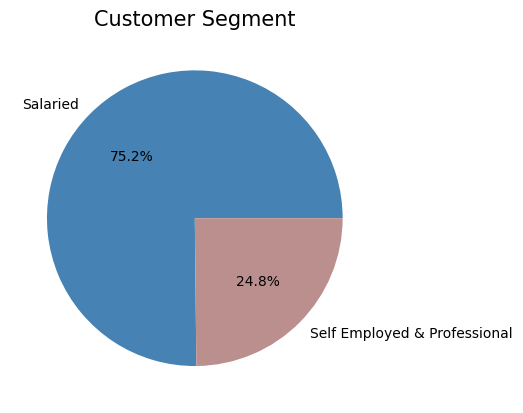

In [42]:
plt.pie(segment_count, labels = segment_labels, autopct='%1.1f%%', colors = colors)
plt.title('Customer Segment', fontdict={'fontsize':15})
plt.show

# 3- **Agglomerative Hierarchical Clustering**

>## 3.1 Scaling Data

In [43]:
drop = ['BOOKING_DATE', 'MATURITY_DATE', 'DOB', 'TENOR_@Booking', ' DPD', 'AGE at Maturity', 'GENDER']
data_drop = data.drop(drop, axis=1)
data_scaled = data_drop
data_scaled['Total O/S'] = data_drop['Total O/S']/100000
data_scaled['BOOKING_DATE_year'] = data_drop['BOOKING_DATE_year']%100
data_scaled['MATURITY_DATE_year'] = data_drop['MATURITY_DATE_year']%100

>## 3.2 Dendrogram

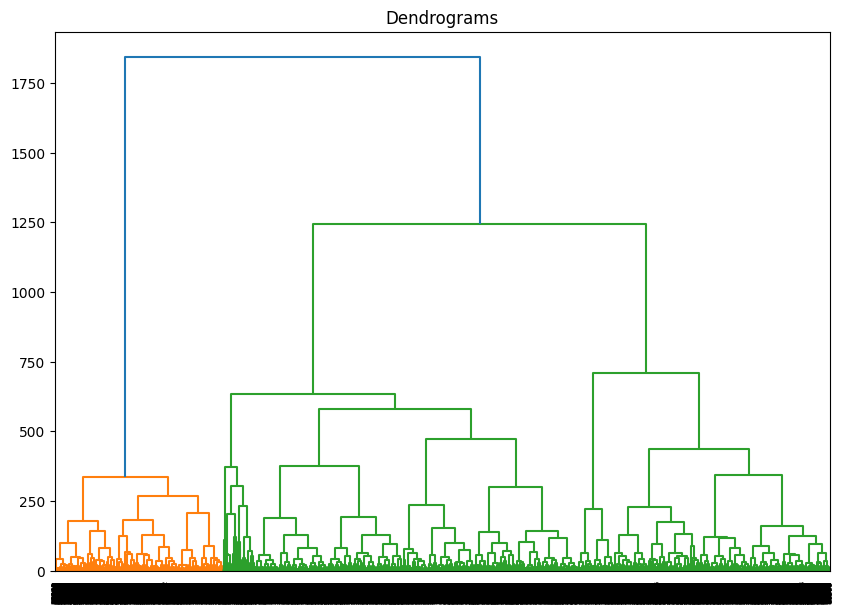

In [44]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(data_scaled, method='ward'))

The x-axis contains the samples and y-axis represents the distance between these samples. The vertical line with maximum distances is the blue line and hence we can decide a threshold of 1500 and cut the dendrogram.

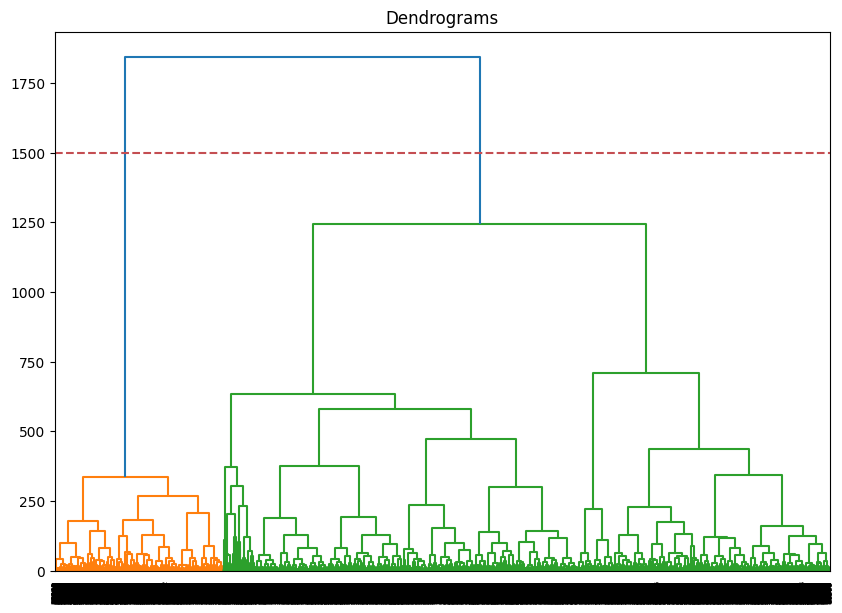

In [45]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(data_scaled, method='ward'))
plt.axhline(y=1500, color='r', linestyle='--')

>## 3.3 Clustering 

In [46]:
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')  
preds = cluster.fit_predict(data_scaled)

>## 3.4 Silhouette Score

In [47]:
score = silhouette_score(data_scaled, preds)
print("For n_clusters = 2 ,silhouette score is {})".format(score))

For n_clusters = 2 ,silhouette score is 0.3646225117373342)


>## 3.5 Visualization Using PCA

In [48]:
pca = PCA()
pca.fit(data_scaled)
pca_data = pca.transform(data_scaled)

In [49]:
# get the component variance
# Proportion of Variance
pca.explained_variance_ratio_

array([0.69829949, 0.14118064, 0.1037989 , 0.04927773, 0.00627507,
       0.00116817])

In [50]:
# Cumulative proportion of variance
np.cumsum(pca.explained_variance_ratio_)

array([0.69829949, 0.83948013, 0.94327903, 0.99255676, 0.99883183,
       1.        ])

In [51]:
# component loadings or weights (correlation coefficient between original variables and the component) 
# component loadings represents the elements of the eigenvector
# the squared loadings within the PCs always sums to 1
loadings = pca.components_
num_pc = pca.n_features_
pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['variable'] = data_scaled.columns.values
loadings_df = loadings_df.set_index('variable')
loadings_df

,PC1,PC2,PC3,PC4,PC5,PC6
variable,,,,,,
Total O/S,-0.018477,0.081034,0.863573,0.495448,0.021634,0.037366
Loan Term,0.046793,0.413293,-0.314972,0.518152,-0.673665,-0.074077
AGE,-0.993295,0.112019,-0.026358,-0.009447,0.005074,-0.002613
Customer Segment,0.000915,0.022473,-0.055473,0.020259,-0.054210,0.996528
MATURITY_DATE_year,0.103756,0.889495,0.013173,-0.182760,0.405484,0.006352
BOOKING_DATE_year,0.008226,0.135525,0.388701,-0.672421,-0.615082,-0.001216


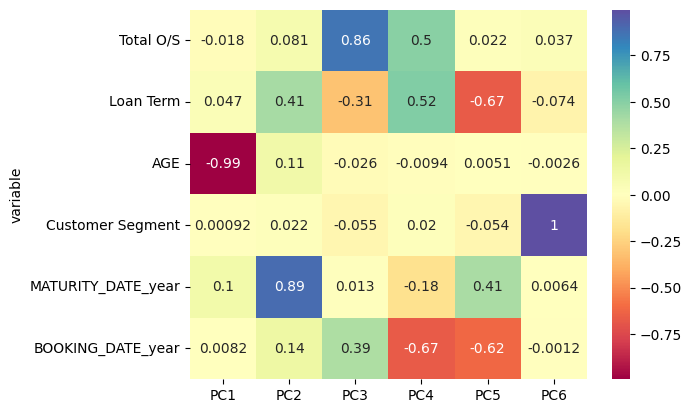

In [52]:
# get correlation matrix plot for loadings
ax = sns.heatmap(loadings_df, annot=True, cmap='Spectral')
plt.show()

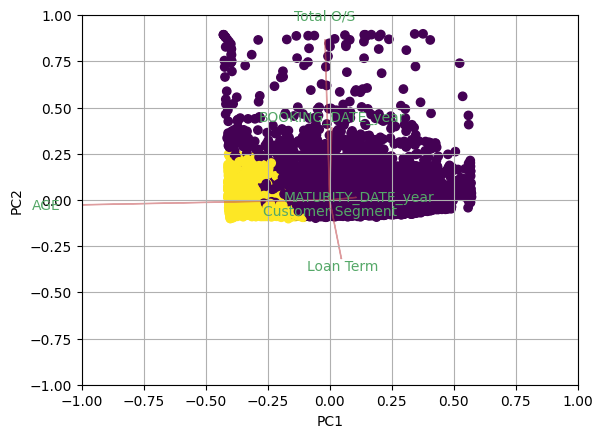

In [53]:
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = cluster.labels_)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

#Call the function. Use only the 2 PCs.
myplot(pca_data[:,[0,2]],np.transpose(pca.components_[[0,2], :]), labels = data_scaled.columns.values)
plt.show()

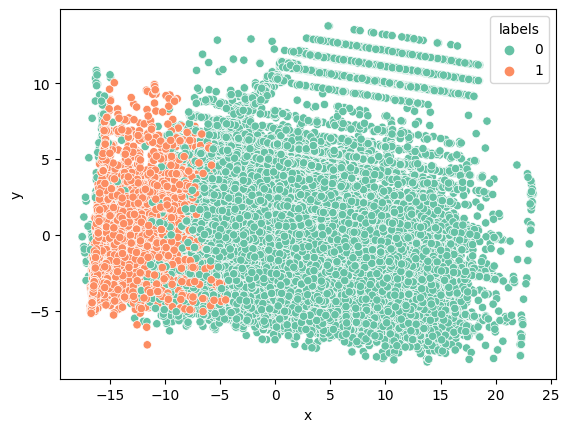

In [54]:
names = ['x', 'y', 'z']
pca = PCA(n_components=2)
pca.fit(data_scaled)
matrix = pca.transform(data_scaled)
df_matrix = pd.DataFrame(matrix)
df_matrix.rename({i:names[i] for i in range(2)}, axis=1, inplace=True)
df_matrix['labels'] = cluster.labels_
pca_data = df_matrix
sns.scatterplot(x=pca_data.x, y=pca_data.y, hue=pca_data.labels, palette="Set2")
plt.show()

>## 3.6 Visulaozation Using T-SNE

In [55]:
tsne = TSNE(n_components = 2)
tsne_data = tsne.fit_transform(data_scaled)

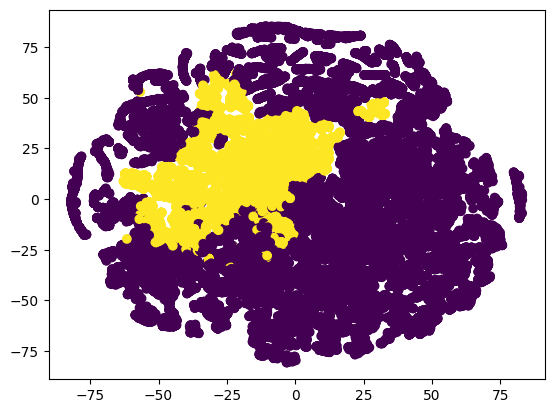

In [56]:
plt.scatter(tsne_data[:,0], tsne_data[:,1], c = cluster.labels_)